# Reinforced learning AAA - Intentionally Blank

If possible, run this notebook through Google Colab because running and testing the notebook was primarily done in Google Colab. Keep in mind the execution time in google colab is around ~35 minutes with a T4 Cuda gpu.
The following link forwards to the Google Colab version of this notebook: https://colab.research.google.com/drive/1lp6nkAk7B3cTZ4k0l3Dp0BetMAuLO9NW?usp=sharing

**Dependencies needed for this notebook:**
* Matplotlib
* Simpy
* Numpy
* pytorch

In [1]:
!pip install simpy

## Imports

In [2]:
import math
import random
from collections import namedtuple, deque
from itertools import count

import matplotlib
import matplotlib.pyplot as plt

import simpy
import numpy as np
np.random.seed(0)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## The simulation

Before creating the DQN agent and using it, we need to create the most important part, the simulation for the car driving and charging.

The reward function is as follows: ${r(time, rate, empty) =-(\sum _{time\in T}a_{time}e^{rate} + empty*400)}$

Where $a_{time}$ is the time coefficient, $rate$ the charging rate and $empty$ the truth value of the battery going empty or not.

In [3]:
# Creating a "Car" class which can drive and charge
class Car(object):
  """
    A simulation of a car's charging and driving behavior.

    Parameters
    ----------
        env : (simpy.Environment)
            The simulation environment.
        battery_level : (float)
            Initial battery charge level in kWh.
        episodes (int):
            Number of simulation episodes.
        n_charging_rates : (int, optional)
            Number of different charging rates. Default is 4.
        time_coeff : (str or list, optional)
            - If "test": Uses predefined time coefficients.
            - If "random": Generates random time coefficients.
            - If "sequential": Uses sequential time coefficients.
            - If list of length 8: Custom time coefficients.
        mean : (float, optional) Mean energy demand for driving. Default is 35.
        var : (float, optional) Variance of energy demand for driving. Default is 5.
        status_announcement : (bool, optional) Enable status announcements. Default is False.

    Attributes
    ----------
        env : (simpy.Environment) The simulation environment.
        battery : (simpy.resources.container.Container) Battery container holding the energy.
            The capacity is computed by the charging constant times the unique charging rates times four,
        mean_rewards : (numpy.ndarray) Array to store mean rewards for each episode.
        mean_reward : (float) Current mean reward.
        timecoeff : (list) Coefficients for time-based penalties and rewards.
        announcement : (bool) Turns the prints on or off for status announcements.
        fuelempty : (bool) Indicates if the fuel is empty.
        timecounter : (int) Counter for time intervals.
        totalTime : (int) Total simulation time.
        mean : (float) Mean energy demand for driving.
        var : (float) Variance of energy demand for driving.
        reward_step : (float) Current reward step.
        penalty_constant : (float) Penalty constant for fuel empty state.
        charge_constant : (float) Charging constant for penalties.

    Methods
    ----------
        charging_step(charging_rate_i): Simulates a charging step with a given rate.
        driving(): Simulates driving behavior with energy demand.
    """
  def __init__(self, env, battery_level, episodes, n_charging_rates=4, time_coeff = "test", mean = 35, var = 5, status_announcement = False):
    """
        Constructor for the Car class.
        Initializes the car's attributes and parameters.
    """
    self.env = env
    self.charge_constant = 6
    self.n_charging_rates = n_charging_rates
    self.battery = simpy.resources.container.Container(env, capacity=self.charge_constant*(self.n_charging_rates - 1)*4, init=battery_level)
    print(f'The capacity is: {self.battery.capacity}')
    self.mean_rewards = np.zeros(episodes)
    self.mean_reward = 0

    if (time_coeff == "test"):
      self.timecoeff = [10,10,10,10,1,1,1,1]
    elif (time_coeff == "random"):
      self.timecoeff = np.random.rand(10)*10
    elif (time_coeff == "sequential"):
      self.timecoeff = [1,2,3,4,5,6,7,8,9,10]
    elif (type(time_coeff) == list and len(time_coeff) == 8):
      self.timecoeff = time_coeff
    else:
      raise Exception('Type or format not accepted for time coefficients. Please set the time_coeff to "test", "random", sequential" or insert a custom list of length 8.')

    self.announcement = status_announcement
    self.fuelempty = False
    self.timecounter = 0
    self.totalTime = 0
    self.mean = mean
    self.var = var
    self.reward_step = 0
    self.penalty_constant = 400

    print(f'The list of time coefficients: {self.timecoeff}')

  def charging_step(self, charging_rate_i):
    """
        Simulate a charging step with a given charging rate and updates the reward values.

        Parameters
        ----------
            charging_rate_i (int): Index of the charging rate.
    """
    # Reset the fuel empty boolean after each step
    self.fuelempty = False
    # Prints the charging rate and the time if flagged true.
    if self.announcement:
      print(f'Charging at Day {int(self.env.now /24)} and charging step {self.timecounter + 1} at {self.charging_rates_name.get(charging_rate_i)}')
    # If the charging rate is zero or the battery is full we skip the charging
    if charging_rate_i == 0 or self.battery.level == self.battery.capacity:
        if self.announcement:
          print(f'Battery charge at {self.battery.level:.3f} kW')
        self.timecounter = self.timecounter + 1
        self.totalTime = self.totalTime + 1
    # If the charging level would be higher than the battery capacity after
    # charging we charge the battery by the missing amount till the battery is full
    elif (self.battery.level + charging_rate_i*self.charge_constant) > self.battery.capacity:
        self.battery.put(self.battery.capacity - self.battery.level)
        if self.announcement:
          print(f'Battery charge at {self.battery.level:.3f} kW')
        self.timecounter = self.timecounter + 1
        self.totalTime = self.totalTime + 1
    # If the other conditions are not true we charge the battery normally.
    else:
        self.battery.put(charging_rate_i*self.charge_constant)
        if self.announcement:
          print(f'Battery charge at {self.battery.level:.3f} kW')
        self.timecounter = self.timecounter + 1
        self.totalTime = self.totalTime + 1
    # After the last charging rate of the day the car starts driving
    if self.timecounter == 8:
        yield self.env.process(self.driving())
    # Reward function
    if(charging_rate_i == 0):
      self.reward_step = 0 - self.fuelempty*self.penalty_constant
    else:
      self.reward_step =  - (math.exp(charging_rate_i)*self.timecoeff[self.timecounter] + self.fuelempty*self.penalty_constant)
    # Update total mean
    self.mean_reward = self.mean_reward + (
        self.reward_step - self.mean_reward) / self.totalTime
    self.mean_rewards[self.totalTime - 1] = self.mean_reward
    yield env.timeout(0)

  def driving(self):
    """
        Simulate the driving behavior of the car.
    """
    self.timecounter = 0
    if self.announcement:
      print(f'Start driving at Day {int(self.env.now /24)} and hour of day {self.env.now % 24}')
    # Calculate the random energy demand with a normal distribution
    energy_demand = np.random.normal(loc=self.mean, scale=self.var, size=None)
    if energy_demand <= 0:
      pass
    elif(self.battery.level - energy_demand < 0):
      self.battery = simpy.resources.container.Container(env, capacity=72, init=0)
      if self.announcement:
        print(f'Battery charge at {self.battery.level:.3f} kW. Car stops driving.')
        print('Car is towed back home.')
      self.fuelempty = True
    else:
      self.battery.get(energy_demand)
      if self.announcement:
        print(f'Battery charge at {self.battery.level:.3f} kW')
    yield env.timeout(0)

Below we test if the initialisation works like intended.

In [4]:
env = simpy.Environment()
car = Car(env, 0, 100, 4, [1,2,4,9,6,3,4,6])
env.run()

The capacity is: 72
The list of time coefficients: [1, 2, 4, 9, 6, 3, 4, 6]


A helper function for getting the reward of the episode and the states is created to save time later.

In [5]:

def return_reward(env,car, charging_rate_i):
  """
    Simulate a charging step and return the resulting reward and environment states.

    Parameters
    ----------
        env (simpy.Environment): The simulation environment.
        car (Car): The car object to simulate charging and retrieve rewards.
        charging_rate_i (int): Index of the charging rate.

    Returns
    ----------
        tuple: A tuple containing:
            - reward_step (float): Reward obtained from the charging step.
            - battery_status (list): List containing current battery level (kW),
                                     and timecounter (int) of the car.
  """
  proc = env.process(car.charging_step(charging_rate_i))
  env.run(until=proc)
  return car.reward_step, [car.battery.level, car.timecounter]

In [6]:
return_reward(env, car, 0)

(0, [0, 1])

## Reinforcement learning (DQN)

### Implementation of the replay memory and the DQN.

Now that we have a solid simulation for the charging steps and the driving, we can create the DQN and learn on the simulation. The following steps are based on the pytorch example of DQN: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [7]:
# The tuple structure saved into the replay memory.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    """
    A replay memory buffer for storing and sampling transitions.

    Parameters
    ----------
        capacity (int): The maximum episodes saved into replay memory.

    Attributes:
        memory (collections.deque): A double-ended queue to store transitions.

    Methods:
        push(*args): Save a transition to the replay memory.
        sample(batch_size): Randomly sample a batch of transitions.
        __len__(): Return the current number of stored transitions.
    """
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

We create a simple Deep-Q Network consisting of 3 hidden layers each consisting of 128 nodes. Relu activation function is used after each hidden layer except the last one. Adding more layers or more nodes did not increase the performance by much if at all.

In [8]:
class DQN(nn.Module):
    """
    Deep Q-Network (DQN) architecture for reinforcement learning.

    Parameters
    ----------
        n_observations (int): Number of states.
        n_actions (int): Number of different actions.
    """
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Forward function
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Because the success of if the DQN learns the most optimal policy heavily depends on the hyperparameters, we tested many combinations. In the code below are the hyperparameters with the best mean reward for the last 200 episodes and the most consistent learning behaviour. We found out that the most difference in performance was due to the "TAU" value and the "GAMMA" value followed by the "EPS_DECAY" parameter. The episode duration was also a huge factor, letting the model run insufficient amount of times lead to sub-optimal policies. The right amount of episodes depends on the other hyperparameters.

In [9]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.985
EPS_START = 0.95
EPS_END = 0.0
EPS_DECAY = 10000
TAU = 0.00005
LR = 1e-4

# Get number of actions from charging rates
n_actions = car.n_charging_rates
# Get the number of state observations
n_observations = len([car.battery.level, car.timecounter])

# Initialise a policy network and a target network with the same architecture.
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
# Set the capacity of the replay memory higher than the number of episodes
# to ensure no negative learning behaviours due to the model "forgetting"
memory = ReplayMemory(300000)


steps_done = 0

# Select next action with the policy network.
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # If the random value is higher than the eps_threshold the next action will be
    # determined by the policy network else it will be selected randomly.
    if sample > eps_threshold:
        with torch.no_grad():
            # Returns the index of the highest value used as the next action.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randint(0, n_actions -1)]], device=device, dtype=torch.long)

episode_reward = []

# Helper function for plotting the reward of each episode
def plot_reward(show_result=False):
    plt.figure(1,figsize=(12,8))

    episode_t = torch.tensor(episode_reward, dtype=torch.float)
    plt.title('Reward per charging step (closer to 0 is better)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(episode_t.numpy())
    plt.show()

The optimize_model function below was mostly taken from the pytorch example linked above and performs a single optimization step.

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state],0)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

The whole trainings loop is stated below. We create a new simpy environment with 1 car. The number of episodes is depending on the availability of a cuda gpu. The first state is made with the initialised values of the battery level and the time counter (e.g. the charging step of the day) of the car. <br>
The number of episodes if no Cuda gpu is available is not sufficient for the DQN to properly learn a good policy. You will need a Cuda gpu to see the model performing well or wait longer with more episodes.

### Trainings loop

The capacity is: 72
The list of time coefficients: [10, 10, 10, 10, 1, 1, 1, 1]
Complete


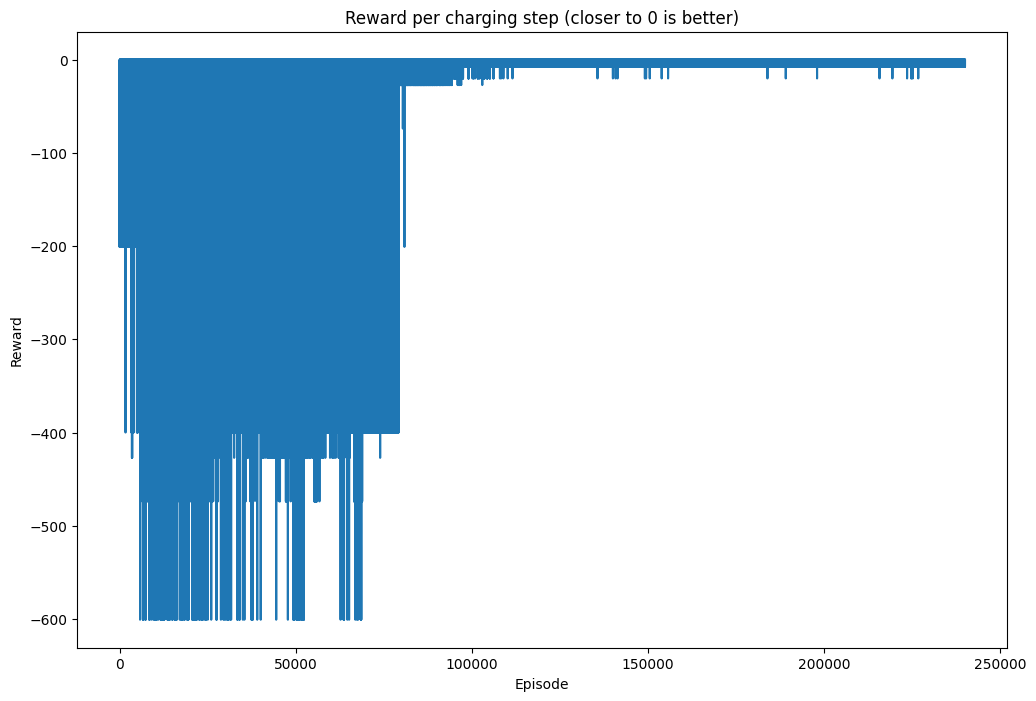

In [11]:
if torch.cuda.is_available():
    num_episodes = 8*30000
else:
    num_episodes = 8*3000

# Initialize the environment and get it's state
env = simpy.Environment()
car = Car(env, battery_level = 0, episodes = num_episodes, n_charging_rates = 4, time_coeff = "test", mean = 35, var = 5)
state = np.array([car.battery.level, car.timecounter])
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

for i_episode in range(num_episodes):
    # Select the action for the next state
    action = select_action(state)
    # Get the reward and the states from the simulation
    reward, observation = return_reward(env, car, action.item())
    reward = torch.tensor(np.array([reward]), device=device)
    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    # Store the transition in memory
    memory.push(state, action, next_state, reward)
    # Move to the next state
    state = next_state

    # Perform one step of the optimization (on the policy network)
    optimize_model()

    # Soft update of the target network's weights
    # θ′ ← τ θ + (1 −τ )θ′
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)
    # Append the reward to a list for later plotting
    episode_reward.append(reward)

print('Complete')
plot_reward(show_result=True)

### Visualizing the mean reward and the policy of the DQN

To visualize from which episode the algorithm starts converging and how the mean reward behaves over time, we first plot the mean reward after each episode.

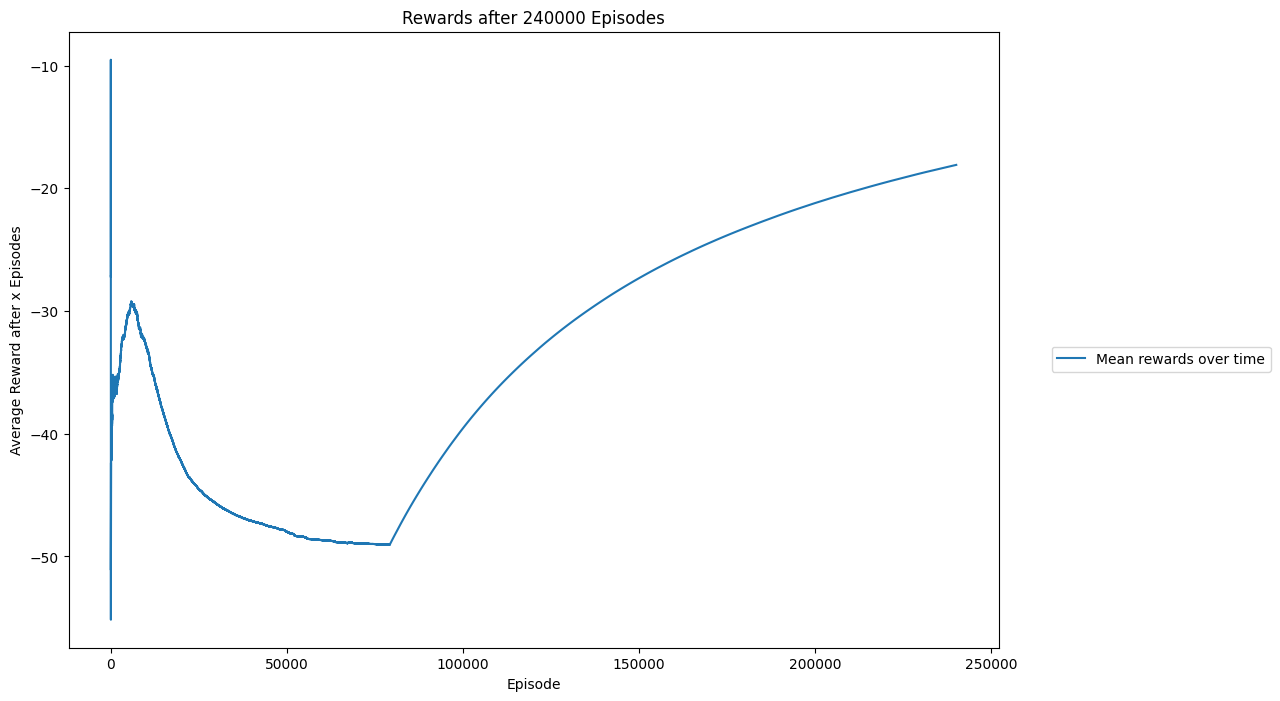

In [12]:
# Plotting mean rewards after each episode
plt.figure(num=2,figsize=(12,8))
plt.plot(car.mean_rewards, label="Mean rewards over time")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episode")
plt.ylabel("Average Reward after x Episodes")
plt.title("Rewards after " + str(num_episodes)
    + " Episodes")
plt.show()

In [13]:
# Output the last mean reward
car.mean_rewards[-1]

-18.08558825465005

We visualize the policy of the DQN by looking at the rewards of the last 200 and 20 episodes. The vertical redlines indicate when a new charging circle (e.g. the next day) starts.

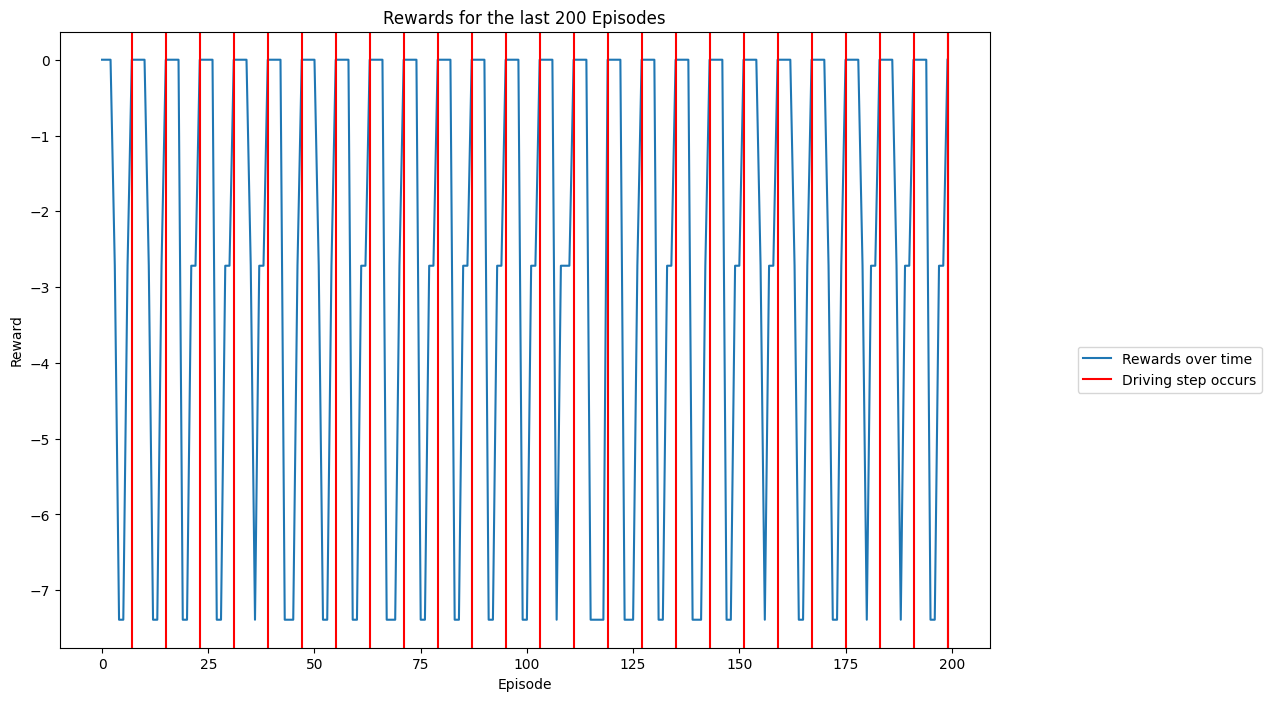

In [14]:
plt.figure(num=2,figsize=(12,8))
plt.plot(torch.tensor(episode_reward, dtype=torch.float).numpy()[-200:], label="Rewards over time")

# Visualizing the driving step after every 8th charging step
plt.axvline(x = 199, color = 'red', label = 'Driving step occurs')
for i in range(math.ceil(199/8)):
  plt.axvline(x = 199 - i*8, color = 'red')

plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Rewards for the last " + str(200)
    + " Episodes")



# rendering plot
plt.show()

In [15]:
# Reward list of the last 200 steps
torch.tensor(episode_reward, dtype=torch.float).numpy()[-200:]

array([ 0.       ,  0.       ,  0.       , -2.7182817, -7.389056 ,
       -7.389056 , -2.7182817,  0.       ,  0.       ,  0.       ,
        0.       , -2.7182817, -7.389056 , -7.389056 , -2.7182817,
        0.       ,  0.       ,  0.       ,  0.       , -7.389056 ,
       -7.389056 , -2.7182817, -2.7182817,  0.       ,  0.       ,
        0.       ,  0.       , -7.389056 , -7.389056 , -2.7182817,
       -2.7182817,  0.       ,  0.       ,  0.       ,  0.       ,
       -2.7182817, -7.389056 , -2.7182817, -2.7182817,  0.       ,
        0.       ,  0.       ,  0.       , -7.389056 , -7.389056 ,
       -7.389056 , -2.7182817,  0.       ,  0.       ,  0.       ,
        0.       , -2.7182817, -7.389056 , -7.389056 , -2.7182817,
        0.       ,  0.       ,  0.       ,  0.       , -7.389056 ,
       -7.389056 , -2.7182817, -2.7182817,  0.       ,  0.       ,
        0.       ,  0.       , -7.389056 , -7.389056 , -7.389056 ,
       -2.7182817,  0.       ,  0.       ,  0.       ,  0.    

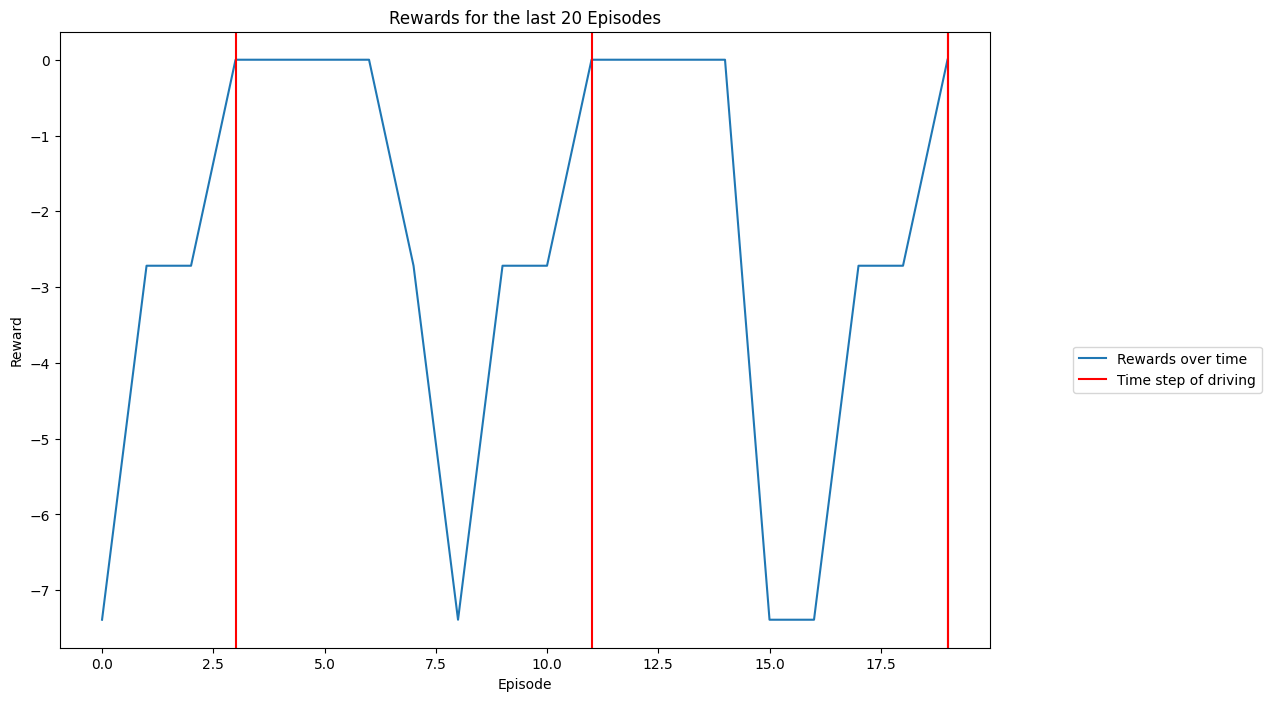

In [16]:
plt.figure(num=2,figsize=(12,8))
plt.plot(torch.tensor(episode_reward, dtype=torch.float).numpy()[-20:], label="Rewards over time")

# Visualizing the driving step after every 8th charging step
plt.axvline(x = 19, color = 'red', label = 'Time step of driving')
for i in range(math.ceil(19/8)):
  plt.axvline(x = 19 - i*8, color = 'red')

plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Rewards for the last " + str(20)
    + " Episodes")

plt.show()

In [17]:
torch.tensor(episode_reward, dtype=torch.float).numpy()[-20:]

array([-7.389056 , -2.7182817, -2.7182817,  0.       ,  0.       ,
        0.       ,  0.       , -2.7182817, -7.389056 , -2.7182817,
       -2.7182817,  0.       ,  0.       ,  0.       ,  0.       ,
       -7.389056 , -7.389056 , -2.7182817, -2.7182817,  0.       ],
      dtype=float32)

In [18]:
np.mean(torch.tensor(episode_reward, dtype=torch.float).numpy()[-200:])

-2.5501883

In [19]:
torch.seed()

6177690928097692502

From the above plots and the list of the rewards we can see that the agent does not charge for the expensive first four periods. Furthermore the agent charges on the lowest time coefficients most of the time with a charging rate of 3, occasionally dipping to a rate of 2 but rarely if not never charging with a rate of 1.